In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/g-research-crypto-forecasting/example_sample_submission.csv
/kaggle/input/g-research-crypto-forecasting/asset_details.csv
/kaggle/input/g-research-crypto-forecasting/example_test.csv
/kaggle/input/g-research-crypto-forecasting/train.csv
/kaggle/input/g-research-crypto-forecasting/supplemental_train.csv
/kaggle/input/g-research-crypto-forecasting/gresearch_crypto/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/g-research-crypto-forecasting/gresearch_crypto/__init__.py


In [2]:
# import packages
import gresearch_crypto
from tensorflow.keras import layers
from IPython import display

import glob
import imageio
import os
import PIL
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd



import random

import pickle
 
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error

In [3]:
# train data - before 2021-06-13
t0 = time.time()
DATA_DIR = '/kaggle/input/g-research-crypto-forecasting/'
def read_csv_strict(file_name='train.csv'):
    df = pd.read_csv(file_name)
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
#     df = df[df['datetime'] < '2021-06-13 00:00:00']
    return df



def read_test_csv(file_name='train.csv'):
    df = pd.read_csv(file_name)
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
    df = df[df['datetime'] >= '2021-06-13 00:00:00']
    return df

train_df = pd.concat([read_csv_strict(DATA_DIR+'train.csv'),
                            read_csv_strict(DATA_DIR+'supplemental_train.csv')])
# train_df = read_csv_strict('/kaggle/input/g-research-crypto-forecasting/train.csv') #train.csv
# test_df = read_test_csv('/kaggle/input/g-research-crypto-forecasting/train.csv') #train.csv

print('elapsed time for loading train_df:', time.time()-t0)

elapsed time for loading train_df: 62.83318519592285


In [4]:
# 데이터 전처리

from sklearn.preprocessing import StandardScaler

def preprocess_data(train_df, number):
    
    # id에 맞는 데이터 불러오기
    bitc = train_df[train_df.Asset_ID == number].set_index('timestamp')

    # 무한대, 무한소 nan으로 치환 
    bitc = bitc.replace([np.inf, -np.inf], np.nan)

    # 이미 존재하는 결측치는 제거
    bitc = bitc.dropna()

    
    # 처음과 끝 시간 사이에 60초 간격으로 range 생성
    bitc_fill_range = range(bitc.index[0], bitc.index[-1]+60, 60)
    
    # 새로운 60초 간격의 range에 맞게 padding하여 데이터프레임 생성
    bitc = bitc.reindex(bitc_fill_range, method='pad') 
    
    # 인덱스로 시간정보가 들어갔으니 datetime 컬럼 drop
    bitc = bitc.drop(columns=['datetime'])

    # scale the data
#     scaler = StandardScaler()
#     scaler = MinMaxScaler()  # test : minmax scale
    scaler = RobustScaler()

    features = bitc.columns.drop(['Target','Asset_ID'])
    bitc_scaled_X = scaler.fit_transform(bitc[features])

    bitc_scaled_X_with_y = pd.concat([pd.DataFrame(bitc_scaled_X, columns=features, index=bitc.index),
                                            bitc['Target']], axis=1)
                                        
    
    df = pd.DataFrame(bitc_scaled_X_with_y, 
                          columns=['Asset_ID', 'Count', 'Open', 
                                   'High', 'Low', 'Close',
                                   'Volume', 'VWAP', 'Target']).drop(columns=['Asset_ID'])
    return bitc_scaled_X_with_y


# preprocess_data(train_df,0)
data_prep = []
asset_list_df = pd.read_csv('/kaggle/input/g-research-crypto-forecasting/asset_details.csv')  #asset_details.csv

for i in range(asset_list_df.Asset_ID.max()+1):
    print(f'{i} preprocessing...')
    data_prep.append(preprocess_data(train_df, i))
    
data_prep[2].head(5)

0 preprocessing...
1 preprocessing...
2 preprocessing...
3 preprocessing...
4 preprocessing...
5 preprocessing...
6 preprocessing...
7 preprocessing...
8 preprocessing...
9 preprocessing...
10 preprocessing...
11 preprocessing...
12 preprocessing...
13 preprocessing...


,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,
1514764860,-0.254237,5.558029,5.615085,5.510651,5.552136,-0.345581,5.548600,-0.004218
1514764920,-0.144068,5.552338,5.619013,5.502389,5.545669,-0.320019,5.543876,-0.004079
1514764980,-0.076271,5.544138,5.621819,5.500984,5.545041,-0.221180,5.555133,-0.002892
1514765040,0.211864,5.556568,5.634445,5.473724,5.540839,-0.246946,5.542926,-0.003718
1514765100,-0.313559,5.547012,5.629395,5.472038,5.539734,-0.402430,5.540819,-0.002171


In [5]:
def datagen(data, seq_len, batch_size, kind):
#     t0 = time.time()
    batch = []
    while True:
        # only use bitcoin (Asset_ID = 2)
        df = random.choice(data)
#         df = data[2]
        input_cols = [c for c in df.columns if c != 'Target']
        index = df.index
        split = int(len(index)*TRAIN_VALID_RATIO)

        if kind == 'train':
            index = index[:split]
        elif kind == 'valid':
            index = index[split:]
            
        while True:
            t = random.choice(index)
            n = np.where(index == t)[0][0] - 1 # 타겟 시각 이전 1개부터 불러옴.
            if n-seq_len+1 < 0:
                continue # seq_len보다 n이 크지 않으면 다시 choice
            frame = df.iloc[n-seq_len+1:n+1]
            # 이전 seq_len만큼의 날들의 데이터를 X, 선택한 날의 Target을 y로 지정하여 append.
            batch.append([frame[input_cols].values, df.loc[t, 'Target']])
            break

        if len(batch) == batch_size:
            X, y = zip(*batch)
            X, y = np.expand_dims(np.array(X), 3), np.array(y)
            yield X, y
            batch = []

            
    

In [6]:
# test datagen
# TRAIN_VALID_RATIO = 0.75
# for X, y in datagen(data_prep, 60, 16, "train"):
# #     print(X, y)
#     break

In [7]:
# 2D CNN model

# seq_len = 15 # 15분
seq_len = 60 # 한시간
# seq_len = 60*24 # 하루?
# seq_len = 60*24*7 # 일주일
# seq_len = 60*24*30 # 한달

# cnn2d shape ref: 
# https://www.researchgate.net/publication/323131323_A_deep_learning_based_stock_trading_model_with_2-D_CNN_trend_detection

# kernel ref :
# https://arxiv.org/pdf/2104.05413.pdf
# 규제
# L2 norm, dropout 적용

### 2d test ###
def cnnpred_2d(seq_len=seq_len, n_features=7, n_filters=(1,1), lambd = 0., droprate = 0.2): #n_filters = (16,32)
    
    # He normalization applied as we use Relu
    init = tf.keras.initializers.HeNormal()
    regularizer=tf.keras.regularizers.l2(lambd)


    model = Sequential([
        Conv2D(n_filters[0], kernel_size=(15, 1), activation='relu', kernel_initializer=init,
               input_shape=(seq_len, n_features, 1)),
        MaxPool2D(pool_size=(2,1)), # 2,1, strides = (2,1)
#         Conv2D(n_filters[1], kernel_size=(int(seq_len*0.2), 1), activation='relu', kernel_initializer=init),
#         MaxPool2D(pool_size=(2,1)),
#         Conv2D(n_filters, kernel_size=(3, 3), activation='relu', kernel_initializer=init,
#                input_shape=(seq_len, n_features, 1)),
#         MaxPool2D(pool_size=(2,1)), # 2,1, strides = (2,1)
#         Conv2D(n_filters, kernel_size=(4, 1), activation='relu'),
#         MaxPool2D(pool_size=(2,1)),
#         Dropout(droprate),
        Flatten(),
        Dense(256, activation='relu',kernel_regularizer=regularizer),
        Dropout(droprate),
        Dense(128, activation='relu',kernel_regularizer=regularizer), # activation 있고 없고의 실제 차이 궁금?
        Dropout(droprate),
        Dense(64, activation='relu',kernel_regularizer=regularizer),
        Dropout(droprate),
        Dense(1, activation='linear')
    ])
    return model

cnnpred_2d().summary()


### 1d test ###
# def cnnpred_1d(seq_len=seq_len, n_features=7, n_filters=8,
#               droprate=0.25):
    
#     model = Sequential([
#         Conv2D(n_filters, kernel_size=(15, 1), activation='relu', 
#                input_shape=(seq_len, n_features, 1)),
#         MaxPool2D(pool_size=(2,1)), # 2,1, strides = (2,1)
#         Conv2D(n_filters, kernel_size=(8, 1), activation='relu'),
#         MaxPool2D(pool_size=(2,1)),
# #         Conv2D(n_filters, kernel_size=(4, 1), activation='relu'),
# #         MaxPool2D(pool_size=(2,1)),
# #         Dropout(droprate),
#         Flatten(),
#         Dense(128, activation='relu'), # activation 있고 없고의 실제 차이 궁금?
#         Dense(64, activation='relu'),
#         Dense(1, activation='linear')
#     ])
#     return model

# cnnpred_1d().summary()


##

2022-01-30 23:48:25.752205: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-30 23:48:25.869183: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-30 23:48:25.869935: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-30 23:48:25.871181: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 7, 1)          16        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 7, 1)          0         
_________________________________________________________________
flatten (Flatten)            (None, 161)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               41472     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

node zero
2022-01-30 23:48:25.873239: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-30 23:48:25.873904: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-30 23:48:27.811347: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-30 23:48:27.812146: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-30 23:48:27.812775: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node r

In [8]:
# pearson coefficient 손실함수, 평가 정의
# from tensorflow.keras import backend as K
 
def plcc_loss(y_true, y_pred):  
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym)))) + 1e-12
    r = r_num / r_den
    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return 1 - K.square(r) 


# def pearson_r(y_true, y_pred):
#     x = y_true
#     y = y_pred
#     mx = tf.reduce_mean(x, axis=1, keepdims=True)
#     my = tf.reduce_mean(y, axis=1, keepdims=True)
#     xm, ym = x - mx, y - my
#     t1_norm = tf.nn.l2_normalize(xm, axis = 1)
#     t2_norm = tf.nn.l2_normalize(ym, axis = 1)
#     cosine = tf.keras.losses.CosineSimilarity(-1,t1_norm, t2_norm)
#     return cosine

def plcc_metric(y_true, y_pred):  
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym)))) + 1e-12
    return r_num / r_den

## 문제점?
1. 예측해야되는게 3달 간의 자료 (3*30*24*60) 인데, 모델 훈련량이 너무 적다..  
한시간 데이터로 계속 먹여주면서 학습인데, epoch 100 / step 50 정도로 충분한지?
2. batch_size, lr 만 하이퍼파라미터 튜닝 해볼것

In [9]:
# final 1d-cnn with all coins -> 
batch_size = 32
n_epochs = 100  # 100
n_features = 7
TRAIN_VALID_RATIO = 0.75

# define RMSE
def RMSE(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# learning rate scheduler
first_decay_steps = 1000
initial_learning_rate = 0.05
lr_decayed_fn = (
#   tf.keras.experimental.CosineDecayRestarts(
#       initial_learning_rate,
#       first_decay_steps))
    tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, first_decay_steps))



# early stopping 
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

# model checkpoint 
mc = ModelCheckpoint('best_model_1dcnn_allcoin.h5', monitor='val_loss', mode='min', save_best_only=True)


t0 = time.time()
model = cnnpred_2d(seq_len=seq_len, n_features=7, n_filters=(1,1),lambd = 0.1, droprate=0.2) #n_filters=(16,32)
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01), 
#               tf.keras.optimizers.Adam(learning_rate=lr_decayed_fn),
#               optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01),
              loss=plcc_loss, metrics=[plcc_metric])
hist = model.fit(datagen(data_prep, seq_len, batch_size, "train"),
         validation_data = datagen(data_prep, seq_len, batch_size, "valid"),
          epochs = n_epochs,
          validation_steps=50, steps_per_epoch=300, #10, 50
          verbose=1, callbacks = [early_stop,mc]
         )
print('total time:', time.time() - t0)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
2022-01-30 23:48:28.672143: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-01-30 23:48:30.273923: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


300/300 [==============================] - 45s 127ms/step - loss: 27.3674 - plcc_metric: -0.0083 - val_loss: 14.5843 - val_plcc_metric: 0.0442
Epoch 2/100
300/300 [==============================] - 41s 136ms/step - loss: 8.9095 - plcc_metric: -0.0291 - val_loss: 5.0667 - val_plcc_metric: 0.0027
Epoch 3/100
300/300 [==============================] - 38s 127ms/step - loss: 3.3461 - plcc_metric: -0.0267 - val_loss: 2.2120 - val_plcc_metric: -0.0271
Epoch 4/100
300/300 [==============================] - 38s 129ms/step - loss: 1.6510 - plcc_metric: 0.0080 - val_loss: 1.3469 - val_plcc_metric: -0.0261
Epoch 5/100
300/300 [==============================] - 38s 129ms/step - loss: 1.1337 - plcc_metric: 0.0535 - val_loss: 1.0972 - val_plcc_metric: -0.0213
Epoch 6/100
300/300 [==============================] - 38s 128ms/step - loss: 0.9834 - plcc_metric: 0.0414 - val_loss: 1.0124 - val_plcc_metric: -0.0408
Epoch 7/100
300/300 [==============================] - 39s 131ms/step - loss: 0.9401 - plcc

In [10]:
# st = StandardScaler()
# stf = st.fit_transform(train_df[train_df.Asset_ID == 0].drop(columns=['timestamp','Asset_ID','datetime']))

# mm = MinMaxScaler()
# mmf = mm.fit_transform(train_df[train_df.Asset_ID == 0].drop(columns=['timestamp','Asset_ID','datetime']))


# plt.plot(stf[:,0],alpha=0.5)
# plt.plot(mmf[:,0],alpha=0.5)

In [11]:
# plt.plot(train_df[train_df.Asset_ID == 0].Count)

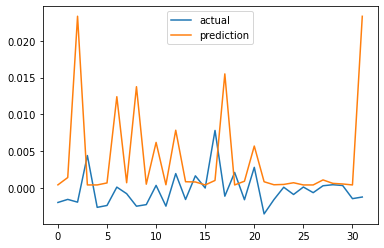

In [12]:
model.load_weights('best_model_1dcnn_allcoin.h5')
for X, y in datagen(data_prep, seq_len, batch_size, "valid"):
    break

plt.plot(y,label='actual')
plt.plot(model.predict(X),label='prediction')
plt.legend()
# # # plt.ylim(-0.01,0.01)
# # # plt.imshow(X[0,:,:,0])

In [13]:
# load model with custom metrics
# model2 = load_model('model_1dcnn_useall_2nd', custom_objects={'RMSE':RMSE,
#                                                              'plcc_metric':plcc_metric})

## Test model for bitcoin only
see the prediction and real 

In [14]:
# preprocess test data
test_prep = []
for i in range(asset_list_df.Asset_ID.max()+1):

    print(f'{i} preprocessing...')
    test_prep.append(preprocess_data(train_df, i).reset_index())
    
test_prep[0].head(5)

0 preprocessing...
1 preprocessing...
2 preprocessing...
3 preprocessing...
4 preprocessing...
5 preprocessing...
6 preprocessing...
7 preprocessing...
8 preprocessing...
9 preprocessing...
10 preprocessing...
11 preprocessing...
12 preprocessing...
13 preprocessing...


,timestamp,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,-0.246154,-0.406261,-0.406301,-0.406030,-0.406241,-0.523286,-0.406174,-0.014399
1,1514764920,-0.235897,-0.406261,-0.406301,-0.406580,-0.406790,-0.527513,-0.406520,-0.015875
2,1514764980,-0.041026,-0.407094,-0.406305,-0.407633,-0.407842,0.364695,-0.407187,-0.015410
3,1514765040,-0.200000,-0.407292,-0.407129,-0.408001,-0.407272,-0.494611,-0.407951,-0.012524
4,1514765100,-0.246154,-0.407299,-0.407338,-0.408654,-0.408862,-0.495089,-0.408708,-0.005940


In [15]:
def testgen_api(df_test, seq_len):
    try:
        # 암호화폐 종류 지정
        coin = test_prep[int(df_test.Asset_ID)]
        
        # test_row의 직전 시간 저장
        last_ts = int(df_test.timestamp) - 60

        # 직전 시간의 데이터 검색
        test_input = coin[coin.timestamp == last_ts]
        last_index = test_input.index[0]

        # 직전 시간부터 그전 seq_len만큼의 길이를 갖는 데이터 반환
        data_to_use = coin.iloc[last_index-seq_len:last_index]

        df = data_to_use.drop(columns=['timestamp'])  # drop Asset_ID
        input_cols = [c for c in df.columns if c != 'Target']

        # CNN 에 맞는 차원으로 변경하여 X, y 생성함
        X = np.expand_dims(np.expand_dims(df[input_cols].values,0),3)
#         y = df['Target'].values

        return X #np.expand_dims(np.array(X), 3), np.array(y)
    
    # 실행 불가 방지를 위해 오류 상황시 zero-matrix로 return 은 하도록 설정.
    except Exception as e:
        print(e, ' 문제가 생겼습니다. asset_id:', row.Asset_ID)
        return np.zeros((1,seq_len,7,1))



0. Test input set 전처리하기 (train + supplementary)
1. Test Data 불러오면
2. Test Data에 맞는 input 데이터를 Test input set 에서 불러옴

3. input 데이터를 tflite 로 생성한 모델에 넣어 predict 수행. (crypto 0~13 반복수행)




## 0. Test input set 전처리

여기서는 train때와 달리 모든 데이터를 이용함

In [16]:
# # 불러온 df_test에서 Asset_ID와 timestamp 를 추출해야 함.
# def testgen_api(df_test, seq_len):
#     try:
#         # 암호화폐 종류 지정
#         coin = test_prep[int(df_test.Asset_ID)]
        
#         # test_row의 직전 시간 저장
#         last_ts = int(df_test.timestamp) - 60

#         # 직전 시간의 데이터 검색
#         test_input = coin[coin.timestamp == last_ts]
#         last_index = test_input.index[0]

#         # 직전 시간부터 그전 seq_len만큼의 길이를 갖는 데이터 반환
#         data_to_use = coin.iloc[last_index-seq_len:last_index]

#         df = data_to_use.drop(columns=['Asset_ID','timestamp'])  # drop Asset_ID
#         input_cols = [c for c in df.columns if c != 'Target']

#         # CNN 에 맞는 차원으로 변경하여 X, y 생성함
#         X = np.expand_dims(np.expand_dims(df[input_cols].values,0),3)
# #         y = df['Target'].values

#         return X #np.expand_dims(np.array(X), 3), np.array(y)
    
#     # 실행 불가 방지를 위해 오류 상황시 zero-matrix로 return 은 하도록 설정.
#     except Exception as e:
#         print(e, ' 문제가 생겼습니다. asset_id:', row.Asset_ID)
#         return np.zeros((1,seq_len,7,1))





# seq_len = 24*60 # 하루
# X = testgen_api(row, seq_len)
# X.shape

3. input 데이터를 tflite 로 생성한 모델에 넣어 predict 수행. (crypto 0~13 반복수행)

In [17]:
# model conversion using tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
interpreter = tf.lite.Interpreter(model_content = tflite_model)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

2022-01-30 23:58:43.136735: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-01-30 23:58:44.057500: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-30 23:58:44.057912: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-01-30 23:58:44.058943: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-01-30 23:58:44.060266: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-30 23:58:44.060641: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had ne

In [18]:

env = gresearch_crypto.make_env()
iter_test = env.iter_test()




for i, (df_test, df_pred) in enumerate(iter_test):
# measure time for an iteration
#     t1 = time.time()
    


    for j, row in df_test.iterrows():
        t0 = time.time()
        
        X = testgen_api(row, seq_len)
        
        interpreter.set_tensor(input_details[0]['index'], X.astype('float32'))
        interpreter.invoke()
        y_pred = interpreter.get_tensor(output_details[0]['index'])

        

        df_pred.loc[df_pred['row_id'] == row['row_id'], 'Target'] = y_pred
#         print('inner cycle: ',time.time() - t0)
        
        
    # Send submissions
    env.predict(df_pred)
#     print(df_pred)
    # measure time
#     print('outer cycle time proceeded: ',time.time() - t1)
    


This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


In [19]:
# for j, row in df_test.iterrows():
#         t0 = time.time()
        
#         X = testgen_api(row, seq_len)
#         t1 = time.time()
#         print(t1 - t0)
#         interpreter.set_tensor(input_details[0]['index'], X.astype('float32'))
#         t2 = time.time()
#         print(t2 - t1)
#         interpreter.invoke()
#         t3 = time.time()
#         print(t3 - t2)
#         y_pred = interpreter.get_tensor(output_details[0]['index'])
#         t4 = time.time()
#         print(t4 - t3)
        

#         df_pred.loc[df_pred['row_id'] == row['row_id'], 'Target'] = y_pred
#         t5 = time.time()
#         print(t5 - t4)
#         print('inner cycle: ',time.time() - t0)

In [20]:
# for j, row in df_test.iterrows():
#         t0 = time.time()
        
#         X = testgen_api(row, seq_len)
#         t1 = time.time()
#         print(t1 - t0)
        
#         y_pred = model.predict(X)
        
# #         interpreter.set_tensor(input_details[0]['index'], X.astype('float32'))
#         t2 = time.time()
#         print(t2 - t1)
# #         interpreter.invoke()
# #         t3 = time.time()
# #         print(t3 - t2)
# #         y_pred = interpreter.get_tensor(output_details[0]['index'])
# #         t4 = time.time()
# #         print(t4 - t3)
        

#         df_pred.loc[df_pred['row_id'] == row['row_id'], 'Target'] = y_pred
#         t5 = time.time()
#         print(t5 - t2)
#         print('inner cycle: ',time.time() - t0)